### Analytical approximation 

Define the switching functions, with both the soft core free energy functional form, and the switches, as descrived in the GROMACS manual. The sigmas and epsilons should be roughly the $\epsilon_{ij}$s between the carbons and the water oxygen.

Modifiers: https://manual.gromacs.org/current/reference-manual/functions/nonbonded-interactions.html

SC: https://manual.gromacs.org/documentation/nightly/reference-manual/functions/free-energy-interactions.html#soft-core-interactions-beutler-et-al


In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt


In [3]:
# for potential switch
def u_lj_sc_shift(r, lam, sigma, epsilon, vdw_switch, vdw, alpha):
    
    # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw 
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Potential switch function
    if r < vdw_switch:
        S_v = 1
    elif vdw_switch <= r < vdw:
        x = (r - vdw_switch) / (vdw - vdw_switch)
        S_v = 1 - 10 * x**3 + 15 * x**4 - 6 * x**5
    else:
        S_v = 0

    # Compute the total potential
    potential = (1 - lam) * V_A + lam * V_B
    potential *= S_v

    return potential


In [10]:
# for force switch
def u_lj_sc_shift_fs(r, lam, sigma, epsilon, vdw_switch, vdw, alpha):
    
    # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw 
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Constantd (given by boundary regions)
    A = - alpha * ((alpha + 4) * vdw - (alpha + 1) * vdw_switch) / vdw ** (alpha + 2) * (vdw - vdw_switch) ** 2
    B = alpha * ((alpha + 3) * vdw - (alpha + 1) * vdw_switch) / vdw ** (alpha + 2) * (vdw - vdw_switch) ** 3

    # force switch function
    if r < vdw_switch:
        S_f = 1
    elif vdw_switch <= r < vdw:
        S_f = A * (r - vdw_switch) ** 2 + B * (r - vdw_switch) ** 3
    else:
        S_f = 0

    # Compute the total potential
    potential = (1 - lam) * V_A + lam * V_B
    potential *= S_f

    return potential


Define the derivative of the energy function $\frac{dU(r,\lambda)}{d\lambda}$ for each of the switching functions.

In [4]:
# potential switch
def u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha):
     # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw [potentials]
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Derivative of the potential
    dU_dlam = V_B - V_A

        
    return dU_dlam

In [11]:
# force switch (assumes rho is 1)
def u_lj_sc_shift_deriv_fs(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, p=1):
     # Soft core correction: calc r_A and r_B
    r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
    r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

    # Hard core vdw [potentials]
    V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
    V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

    # Derivatives of V_A and V_B with respect to r_A and r_B
    dV_A_drA = 4 * epsilon * (-12 * sigma**12 / r_A**13 + 6 * sigma**6 / r_A**7)
    dV_B_drB = 4 * epsilon * (-12 * sigma**12 / r_B**13 + 6 * sigma**6 / r_B**7)

    # Derivatives of r_A and r_B with respect to lambda
    drA_dlambda = (alpha * sigma**6 * p * lam**(p-1)) / (6 * (alpha * sigma**6 * lam**p + r**6)**(5/6))
    drB_dlambda = -(alpha * sigma**6 * p * (1 - lam)**(p-1)) / (6 * (alpha * sigma**6 * (1 - lam)**p + r**6)**(5/6))

    # Derivative of the potential
    dU_dlam = -V_A + V_B + (1 - lam) * dV_A_drA * drA_dlambda + lam * dV_B_drB * drB_dlambda

    return dU_dlam

Define the average of the derivative with respect to $\lambda$, $\left \langle \frac{dU}{d\lambda} \right\rangle$, averaged over the configurations of all the water/solvent in the simulation. Here, because we are not calculating a precise average over a simulation, we have to estimate what this expectation value would be.  

One approximate value would be to approximate $\left \langle \frac{dU}{d\lambda} \right\rangle$ as $\int_0^{\infty} \frac{dU}{d\lambda} g_0(r) 4\pi r^2 dr$, where $g_0(r)$ is the zeroth order (or pairwise) approximation to the radial distribution function, with $g_0(r) = \rho e^{-\beta U(r,\lambda)}$ with the $U(r,\lambda)$ of water and LJ particle defined above. This approximate distribution accounts for pairwise interactions between water, but does not include contributions to the partition function for 3 way particle interactions. But the average integral should converge.

Once one calculates this average, then $\Delta G = \int_{\lambda=0}^{1} \left \langle \frac{dU}{d\lambda} \right\rangle d\lambda$.

In [5]:
#potential switch
def avg_derivative(sigma, epsilon, alpha, lam, rho, k_B, T, vdw, vdw_switch, p=1):
    def integrand(r):
        # Calculate the derivative of the potential
        dU_dlam = u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, disp_corr)
        
        # Soft core correction: calc r_A and r_B
        r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
        r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

        # Hard core vdw [potentials]
        V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
        V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

        # Potential
        U_r_lam = (1 - lam) * V_A + lam * V_B

        # RDF
        g_0_r = rho * np.exp(-(1 / (k_B * T)) * U_r_lam)

        return dU_dlam * g_0_r * 4 * np.pi * r**2

    # Integrate from 0 to vdw_switch
    integral1, _ = spi.quad(integrand, 0, vdw_switch)
    
    return integral1

In [12]:
# force switch
import numpy as np
import scipy.integrate as spi #????
def avg_derivative_fs(sigma, epsilon, alpha, lam, vdw_switch, vdw, rho, k_B, T, p=1):
    def integrand(r):
        # Calculate the derivative of the potential
        dU_dlam = u_lj_sc_shift_deriv_fs(r, lam, sigma, epsilon, vdw_switch, vdw, alpha, p)
        
        # Soft core correction: calc r_A and r_B
        r_A = ((alpha * sigma**6 * lam + r**6)**(1/6))
        r_B = ((alpha * sigma**6 * (1 - lam) + r**6)**(1/6))

        # Hard core vdw [potentials]
        V_A = 4 * epsilon * ((sigma / r_A)**12 - (sigma / r_A)**6)
        V_B = 4 * epsilon * ((sigma / r_B)**12 - (sigma / r_B)**6)

        # Potential
        U_r_lam = (1 - lam) * V_A + lam * V_B

        # RDF
        g_0_r = rho * np.exp(-(1 / (k_B * T)) * U_r_lam)

        return dU_dlam * g_0_r * 4 * np.pi * r**2

    # Integrate from 0 to infinity
    integral, _ = spi.quad(integrand, 0, vdw_switch)
    return integral

The effects of the cutoff are partially corrected by the tail correction factor, which uses the same formula, but approximates $g(r)=1$.  i.e. it is a correction to $U(r,\lambda)$ of $\int_{r_{switch}}^{\infty} U(r,\lambda) 4\pi r^2 dr$, and a correction to $\frac{dU}{d\lambda}(r,\lambda)$ of $\int_{r_{switch}}^{\infty} \frac{dU(r,\lambda)}{d\lambda} 4\pi r^2 dr$.  This is at least for the ``potential-switch``- I will have to check the code (maybe it's in the documentation?) for how this is implemented with ``potential-shift`` and ``force-shift``, since the potential is changing even inside $r_{switch}$!

# Potential Switch

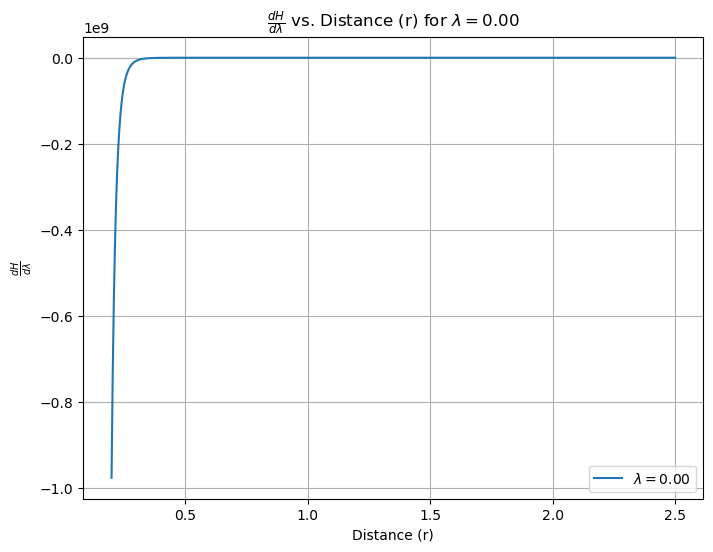

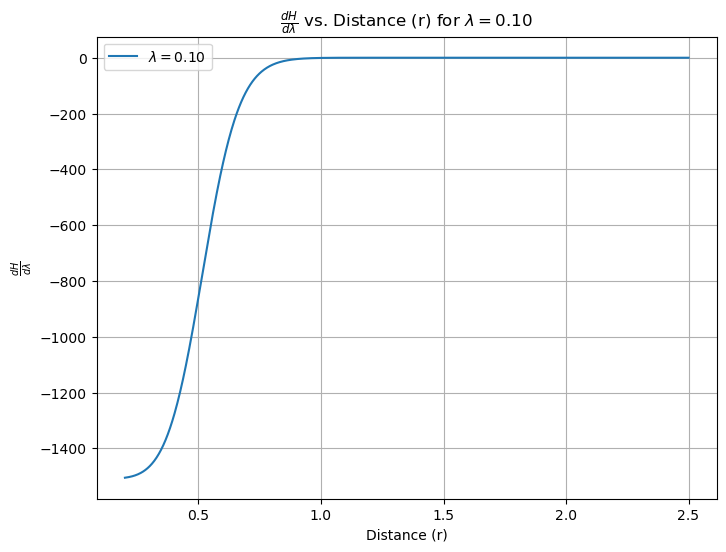

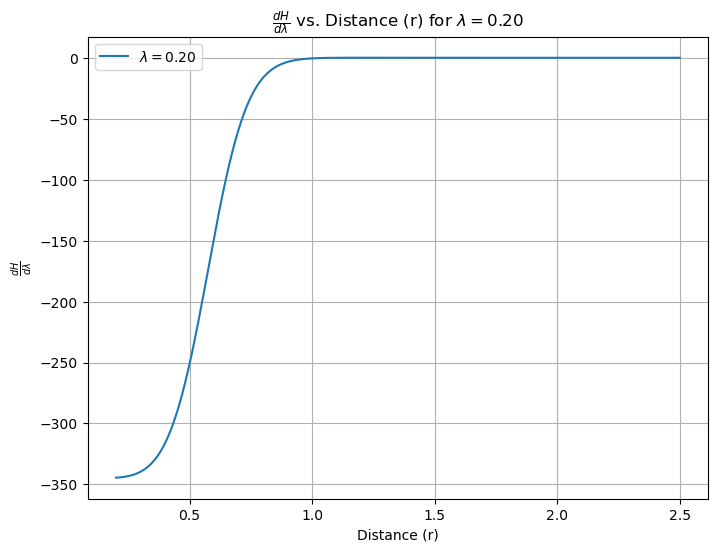

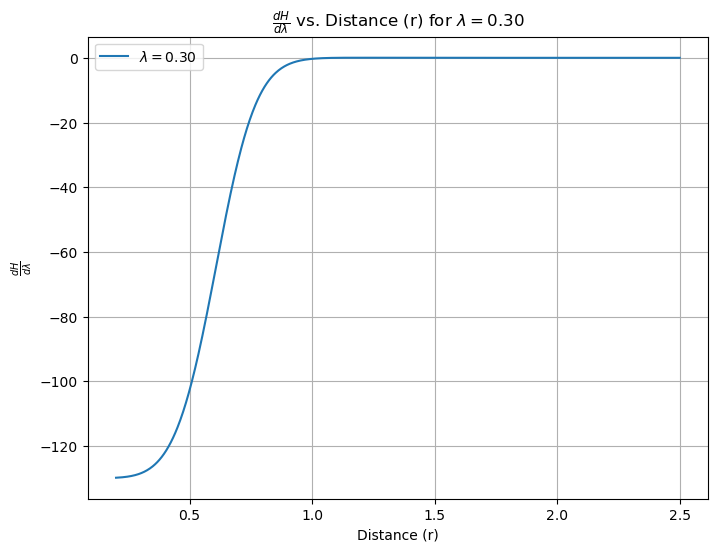

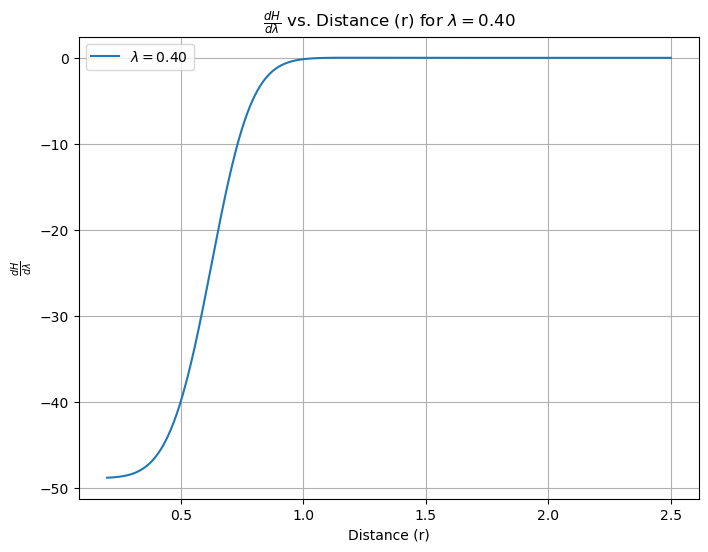

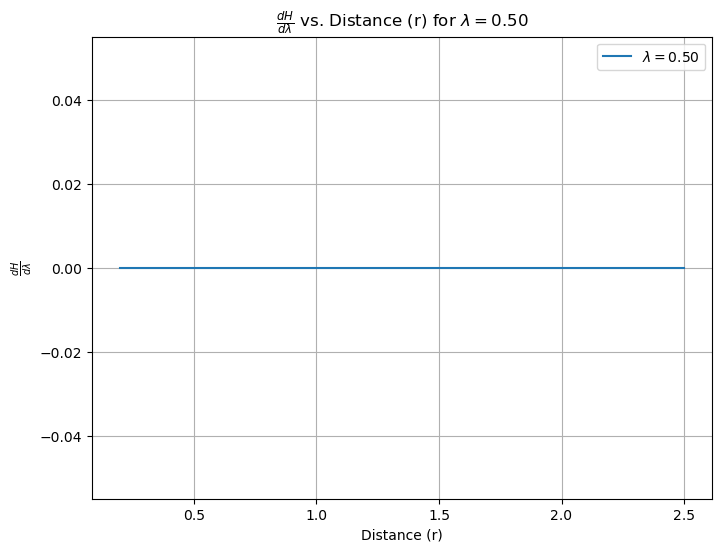

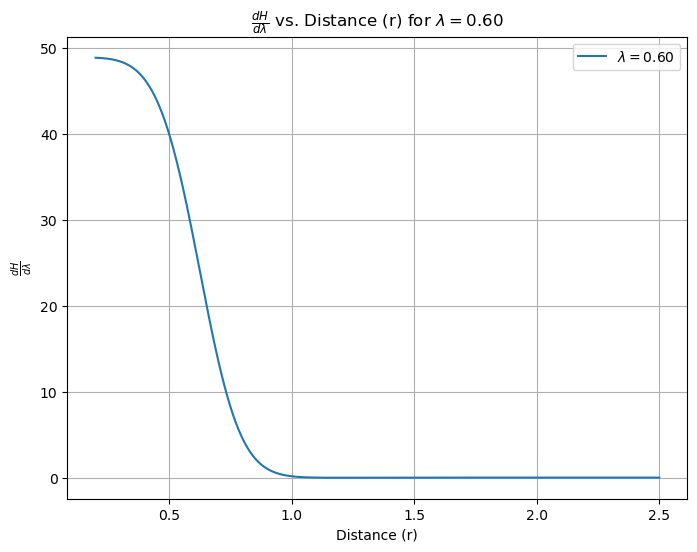

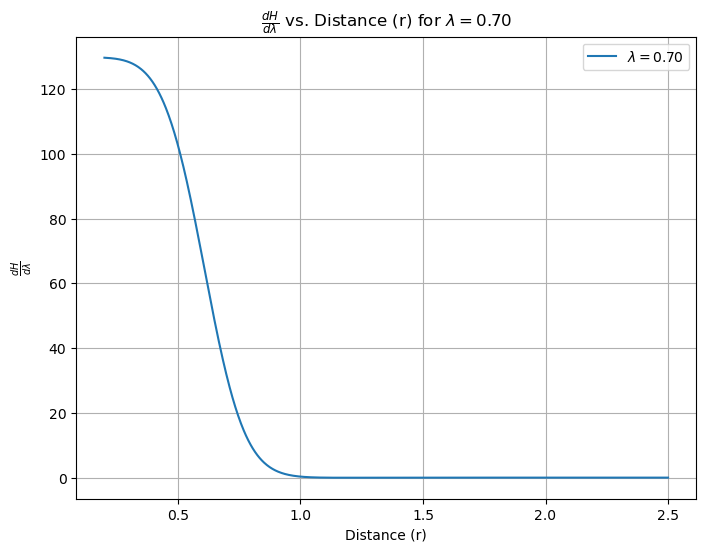

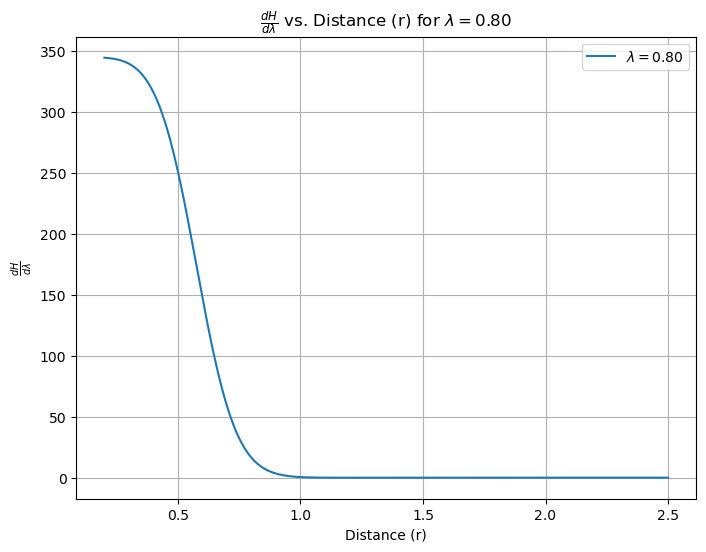

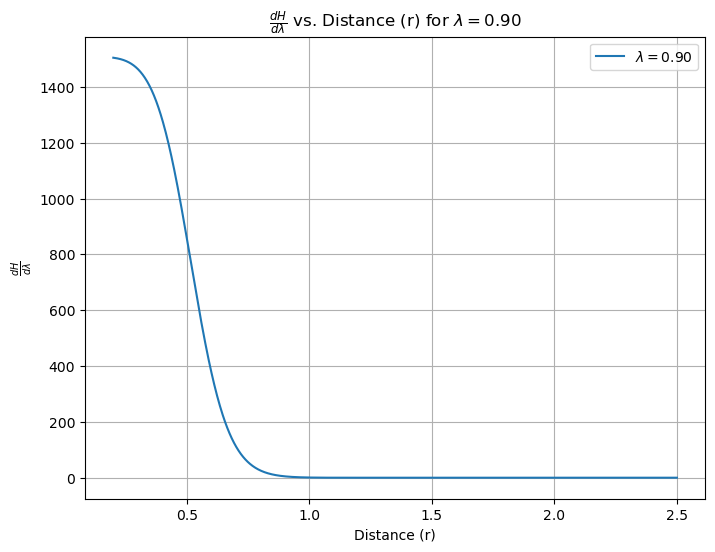

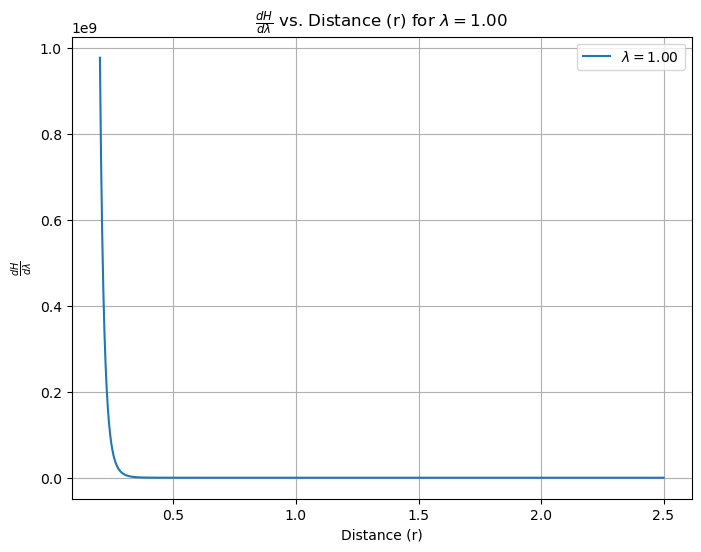

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
vdw_switch = 1.75
vdw = 2.0

# Define r values
r_values = np.linspace(0.2, 2.5, 1000)

# Define lambda values
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Adjust the number of lambda values as needed

# Loop over each lambda value to plot dH/dλ on separate graphs
for lam in lambda_values:
    dhdl_r = [u_lj_sc_shift_deriv(r, lam, sigma, epsilon, vdw_switch, vdw, alpha) for r in r_values]
    plt.figure(figsize=(8, 6))
    plt.plot(r_values, dhdl_r, label=r'$\lambda = {:.2f}$'.format(lam))
    
    plt.xlabel('Distance (r)')
    plt.ylabel(r'$\frac{{dH}}{{d\lambda}}$')
    plt.title(r'$\frac{{dH}}{{d\lambda}}$ vs. Distance (r) for $\lambda = {:.2f}$'.format(lam))
    plt.legend()
    plt.grid(True)
    plt.show()



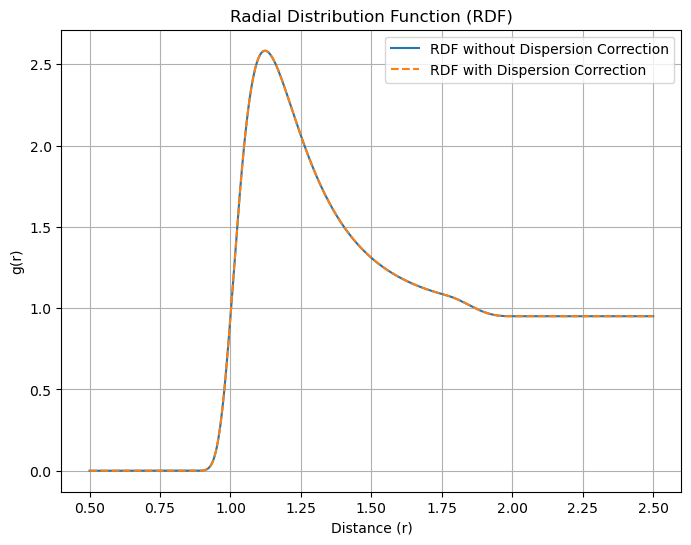

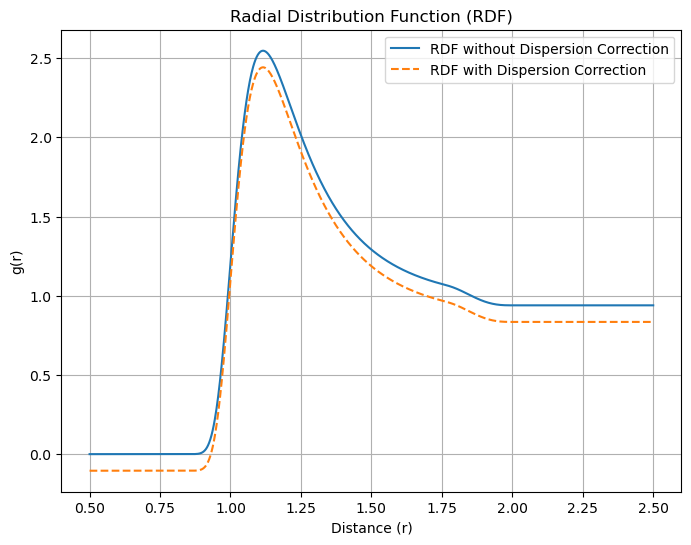

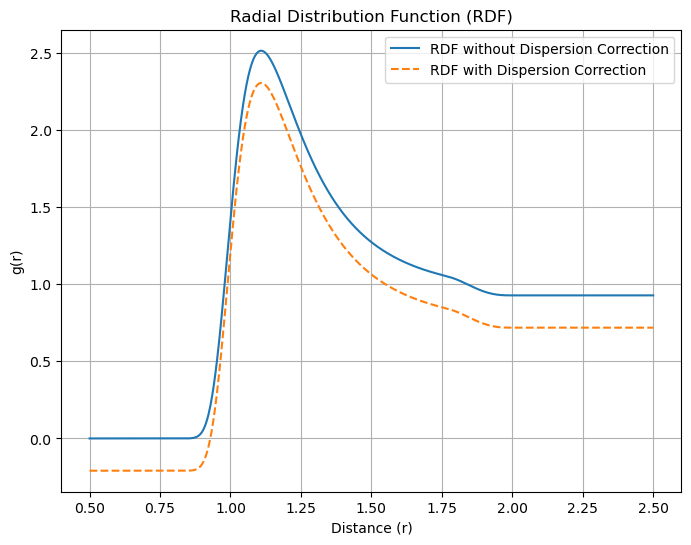

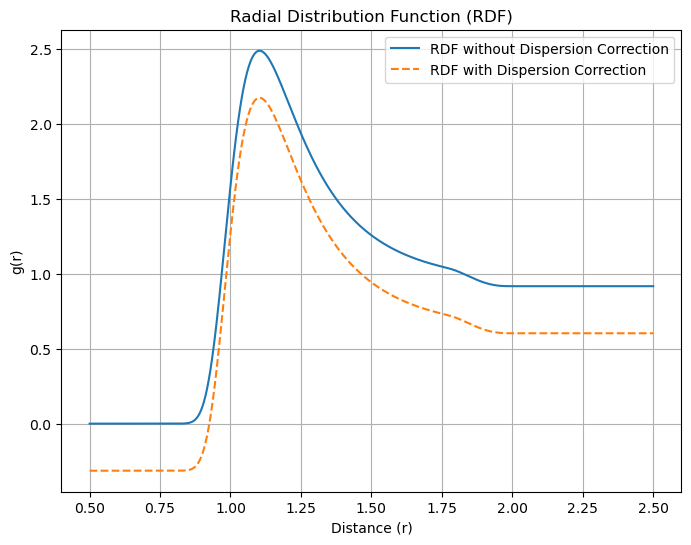

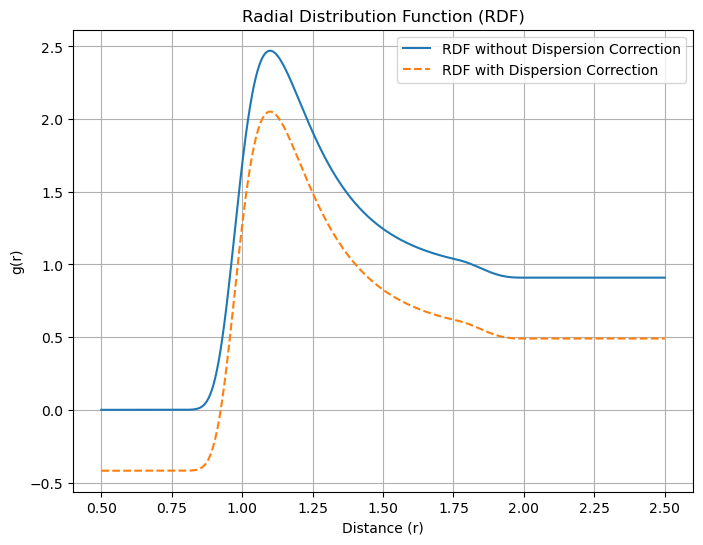

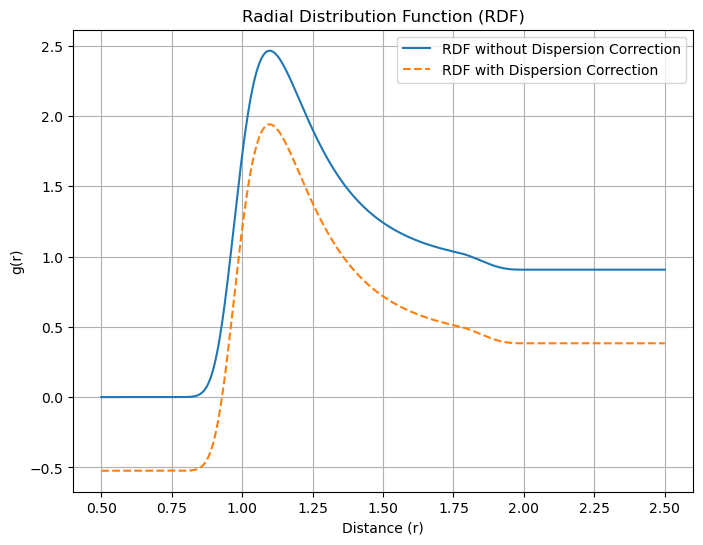

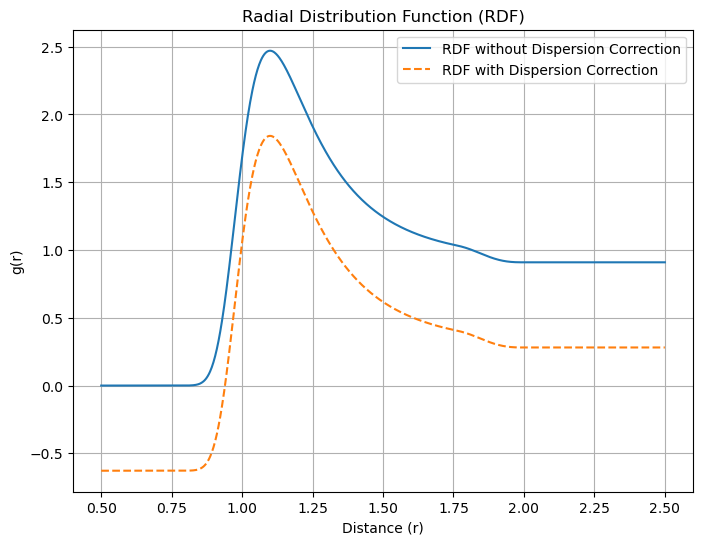

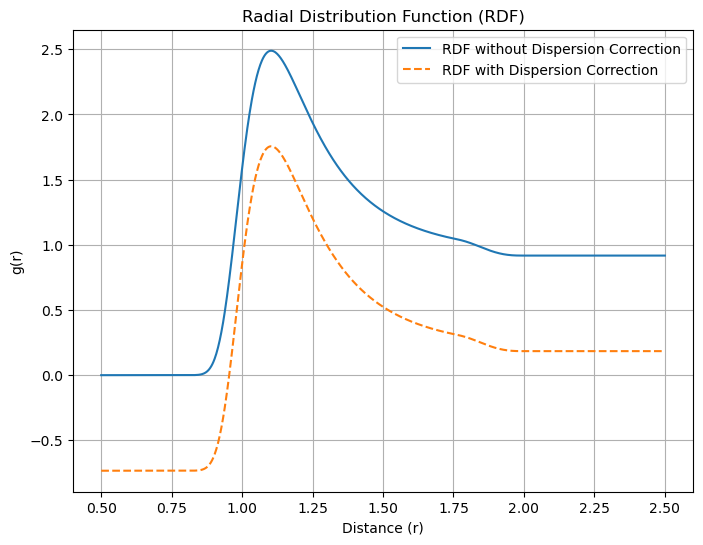

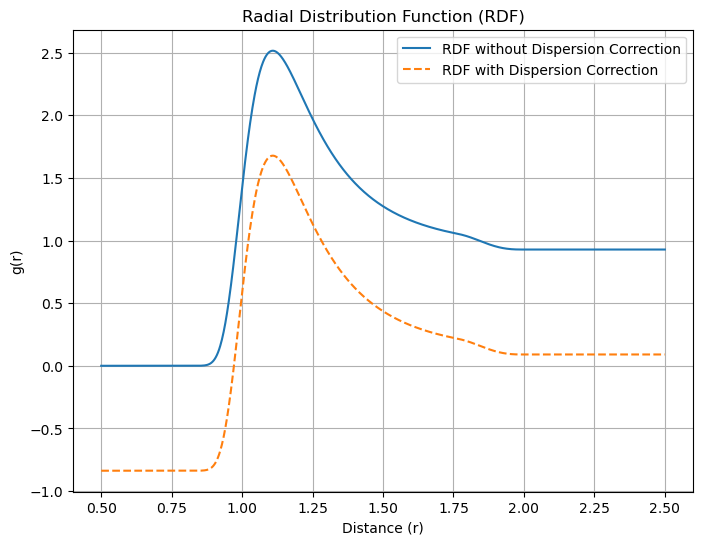

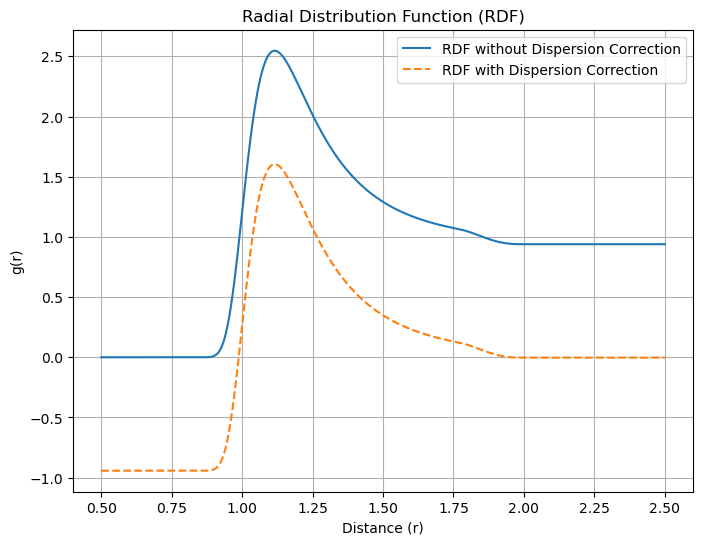

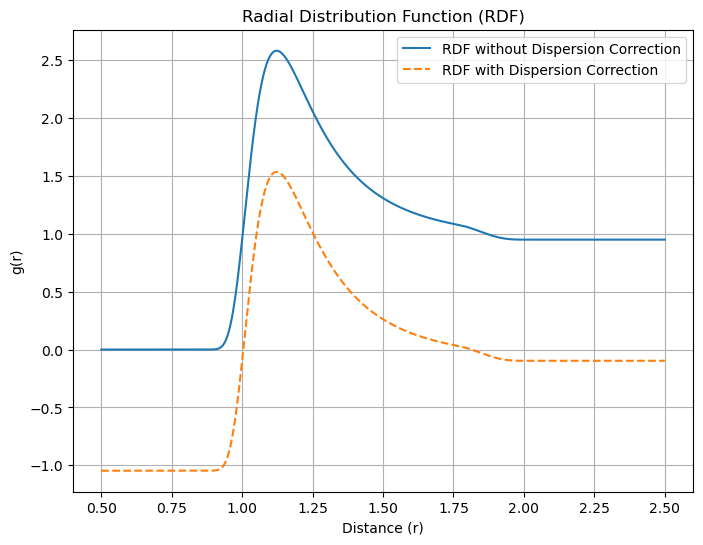

In [9]:

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
lam = 0.5
rho = 1.0  # Density (number of particles per unit volume)
k_B = 1.0  # Boltzmann constant
T = 1.0    # Temperature
vdw_switch = 1.75
vdw = 2.0

# Function to compute RDF
def compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T):
    g_r = np.exp(-np.array([u_lj_sc_shift(r_i, lam, sigma, epsilon, vdw_switch, vdw, alpha) for r_i in r_values]) / (k_B * T))
    g_r /= np.mean(g_r)  # Normalize RDF
    return g_r

# Distance range for RDF calculation
r_values = np.linspace(0.5, 2.5, 1000)
for lam in lambda_values:
    # Calculate RDF without dispersion correction
    g_r_no_corr = compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T)

    # Calculate RDF with dispersion correction
    disp_corr = -8 * np.pi * epsilon * (sigma**6) / (3 * vdw**3)
    g_r_with_corr = g_r_no_corr + lam * disp_corr

    # Plot RDFs
    plt.figure(figsize=(8, 6))
    plt.plot(r_values, g_r_no_corr, label='RDF without Dispersion Correction')
    plt.plot(r_values, g_r_with_corr, label='RDF with Dispersion Correction', linestyle='--')
    plt.xlabel('Distance (r)')
    plt.ylabel('g(r)')
    plt.title('Radial Distribution Function (RDF)')
    plt.legend()
    plt.grid(True)
    plt.show()



# Force switch

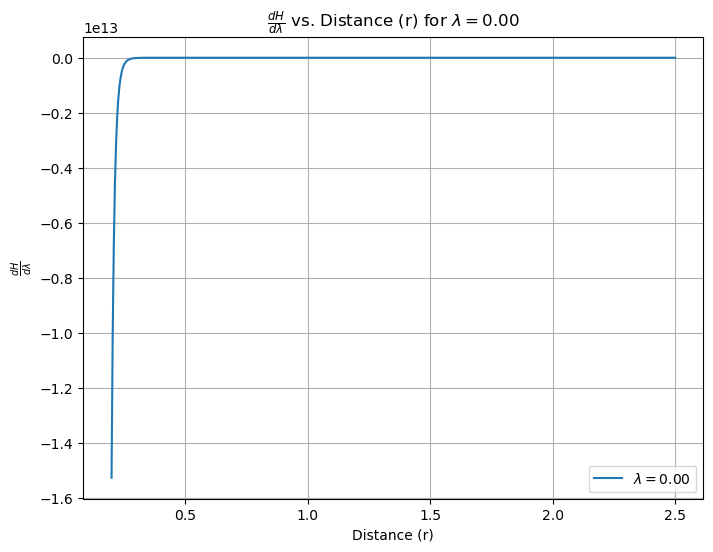

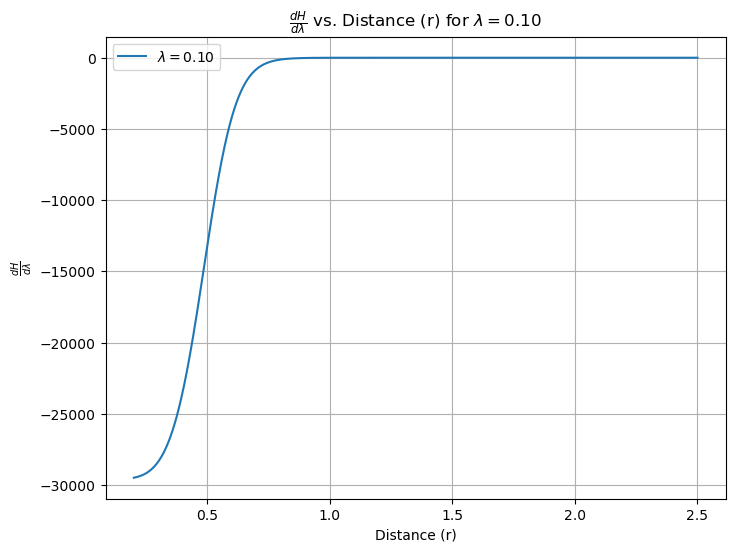

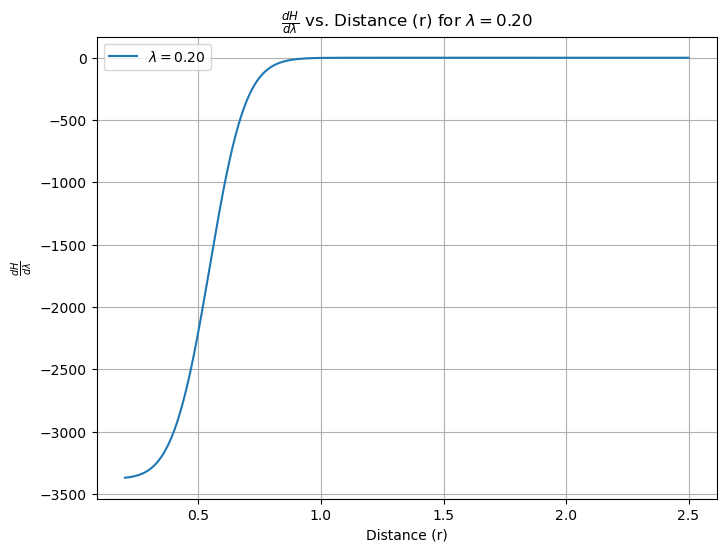

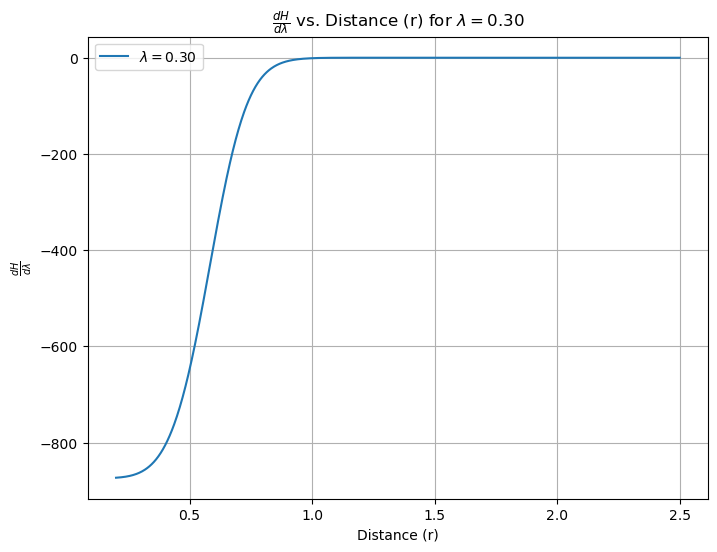

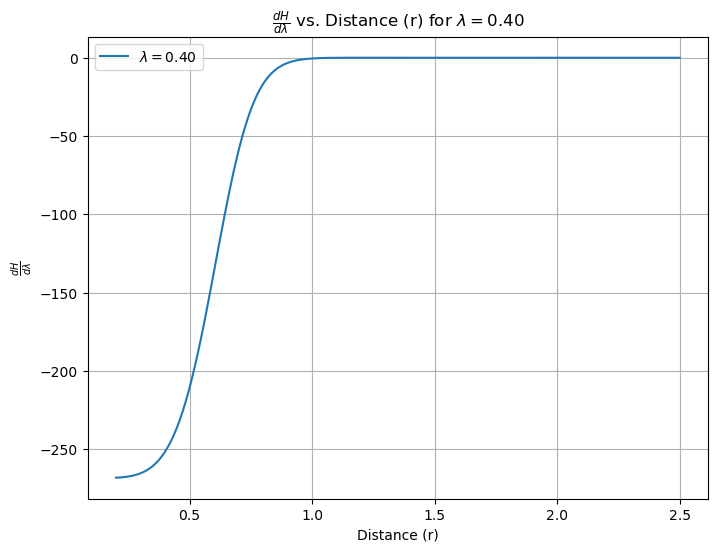

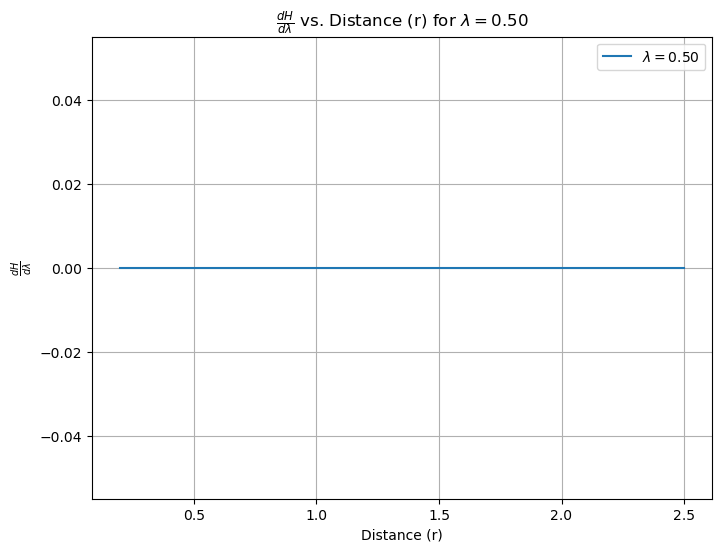

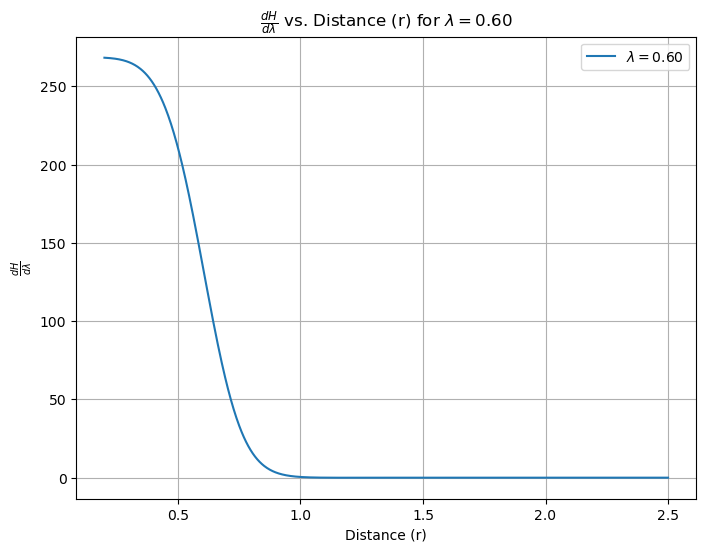

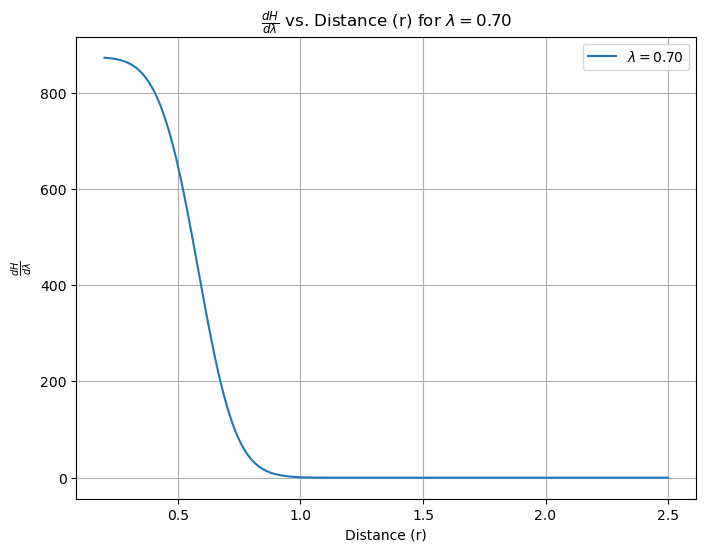

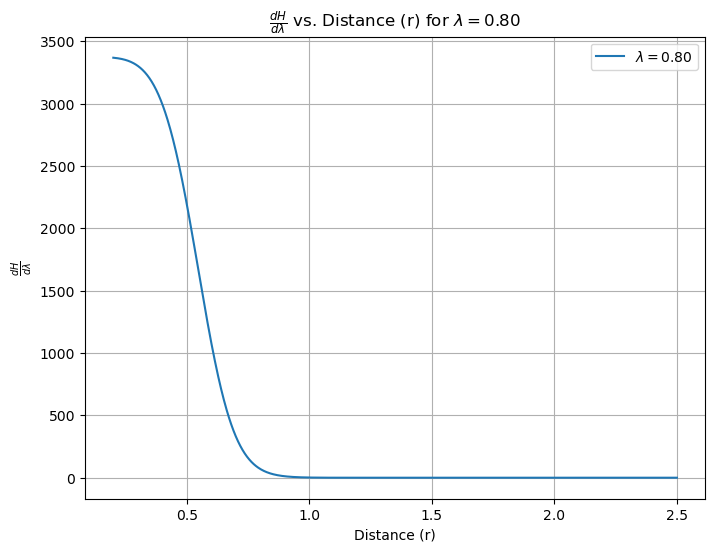

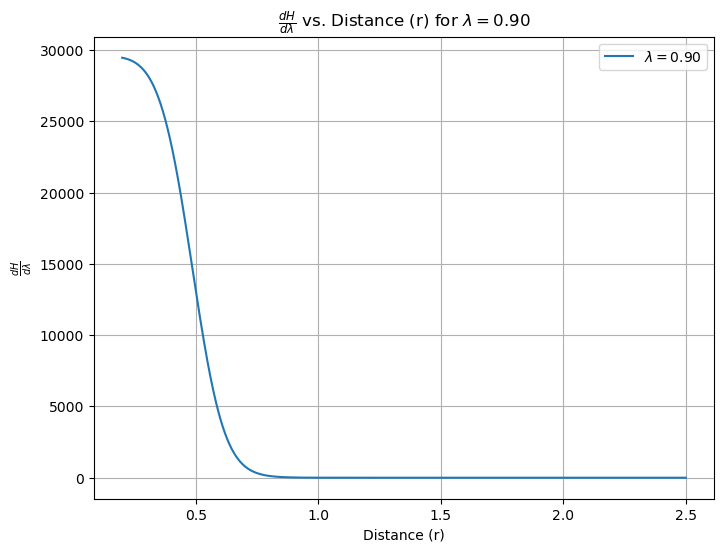

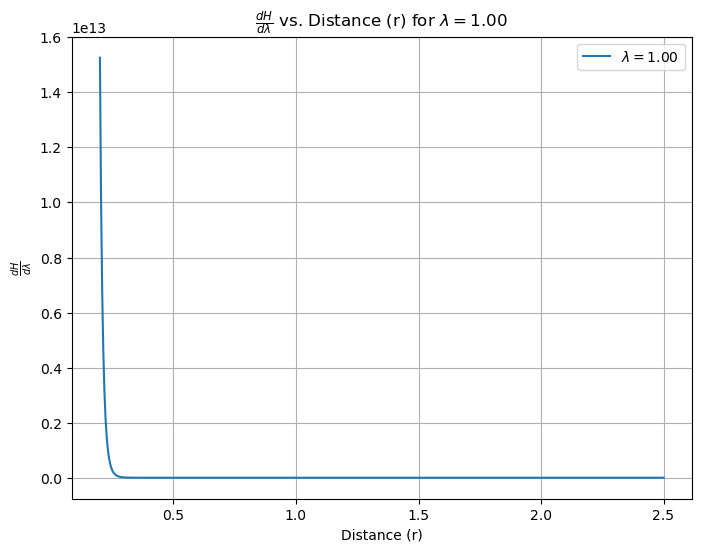

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
vdw_switch = 1.75
vdw = 2.0

# Define r values
r_values = np.linspace(0.2, 2.5, 1000)

# Define lambda values
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Adjust the number of lambda values as needed

# Loop over each lambda value to plot dH/dλ on separate graphs
for lam in lambda_values:
    dhdl_r = [u_lj_sc_shift_deriv_fs(r, lam, sigma, epsilon, vdw_switch, vdw, alpha) for r in r_values]
    plt.figure(figsize=(8, 6))
    plt.plot(r_values, dhdl_r, label=r'$\lambda = {:.2f}$'.format(lam))
    
    plt.xlabel('Distance (r)')
    plt.ylabel(r'$\frac{{dH}}{{d\lambda}}$')
    plt.title(r'$\frac{{dH}}{{d\lambda}}$ vs. Distance (r) for $\lambda = {:.2f}$'.format(lam))
    plt.legend()
    plt.grid(True)
    plt.show()

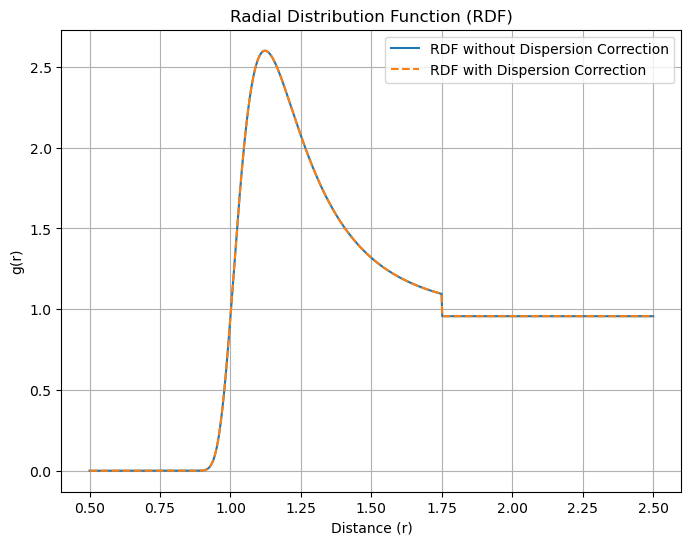

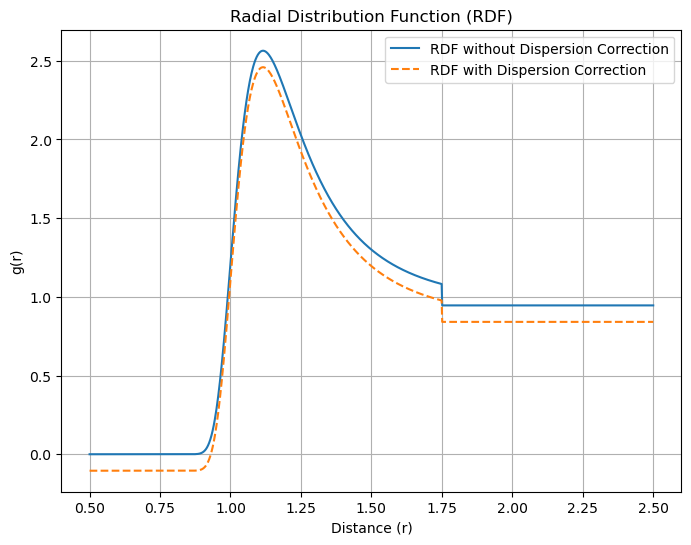

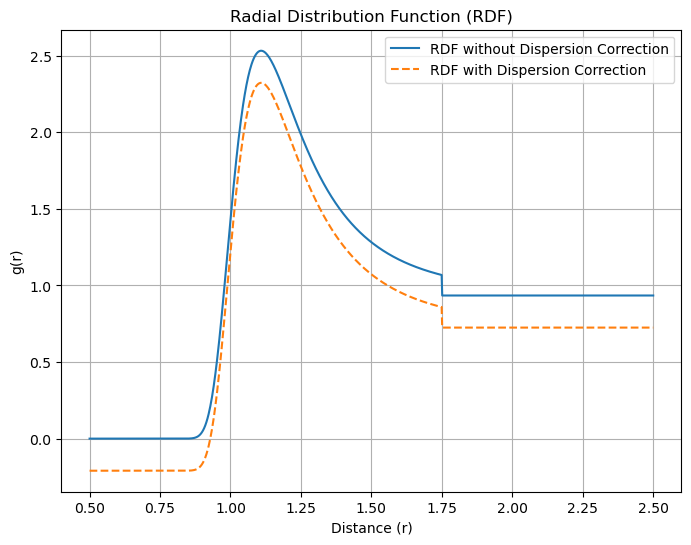

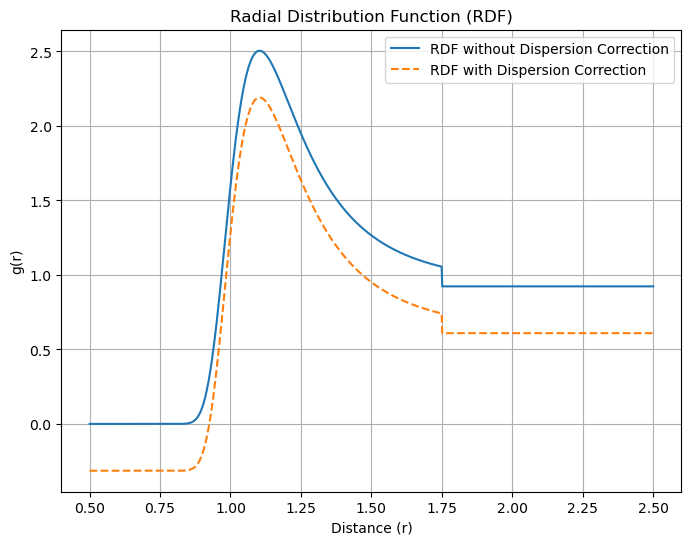

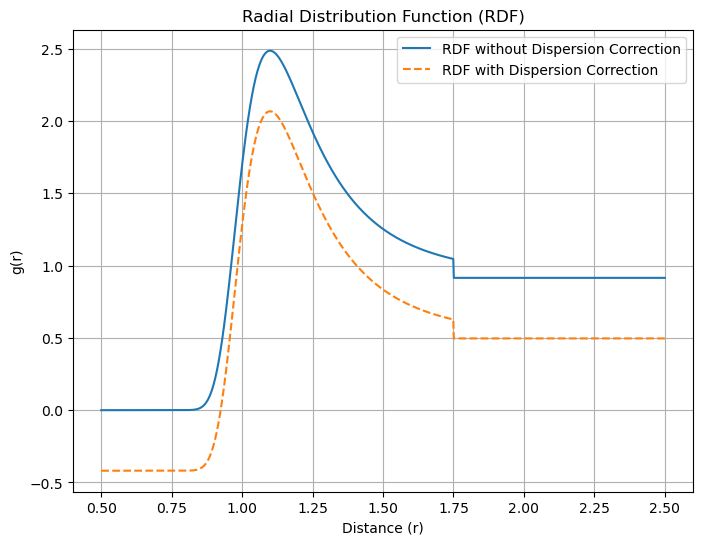

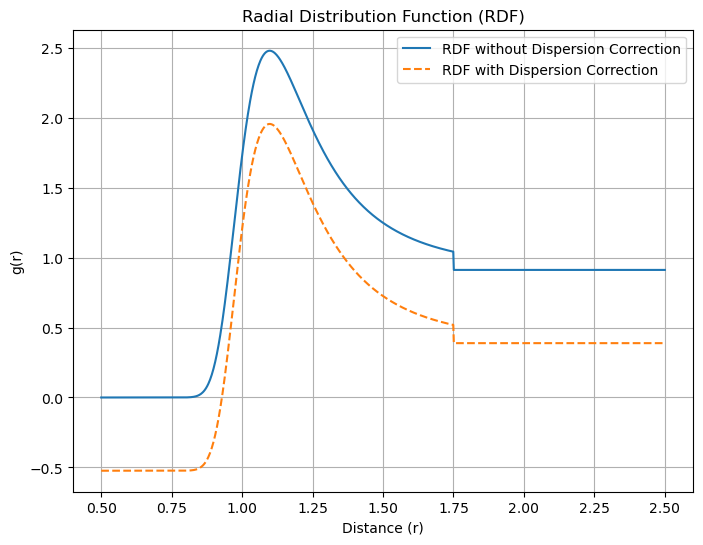

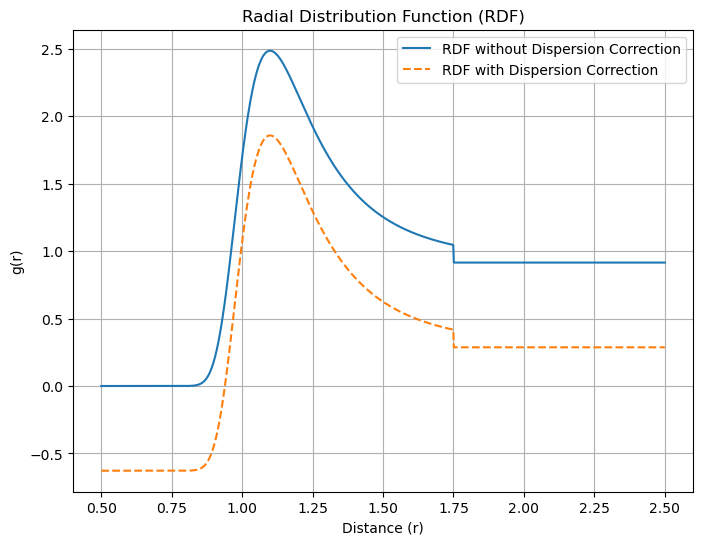

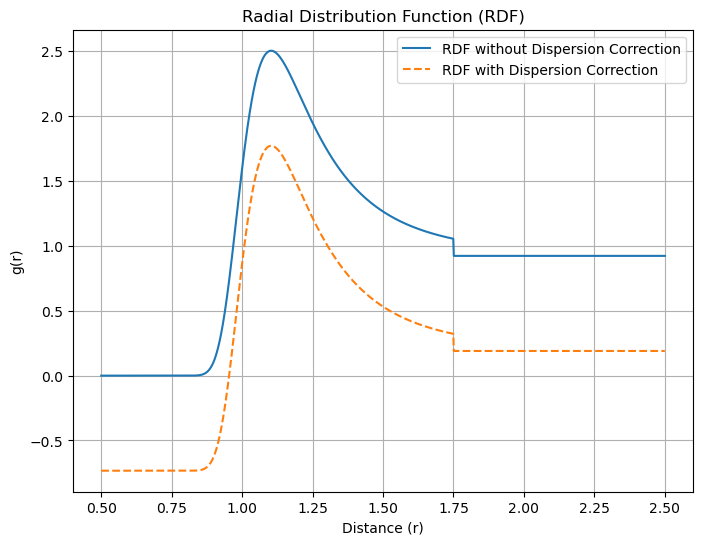

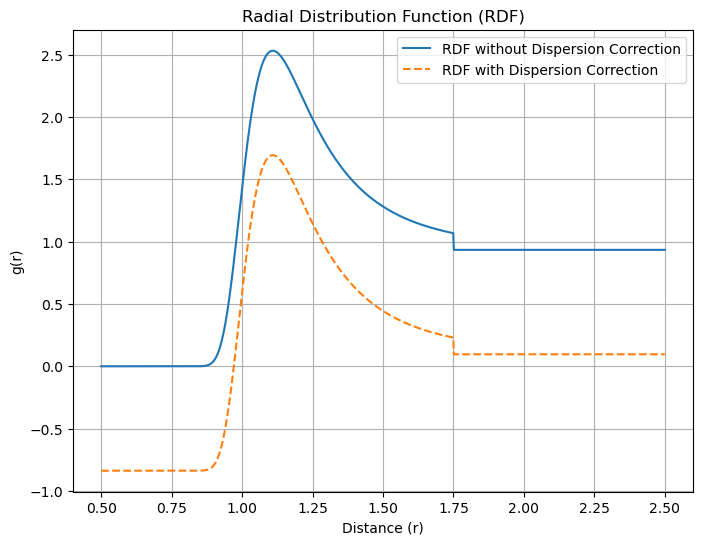

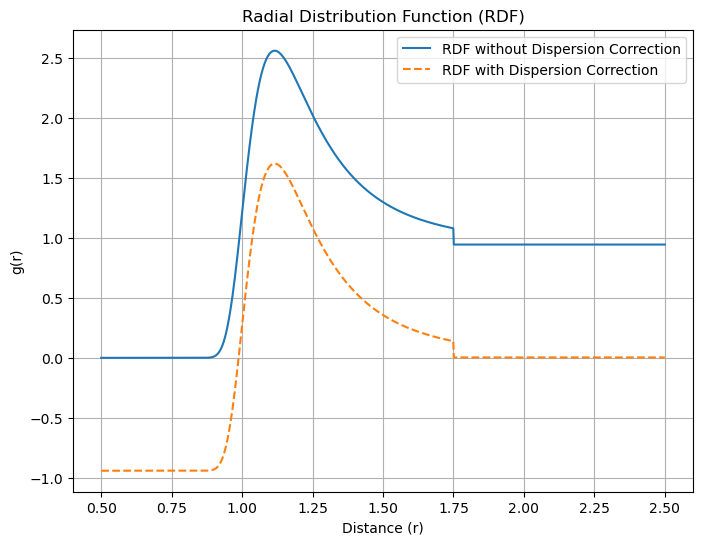

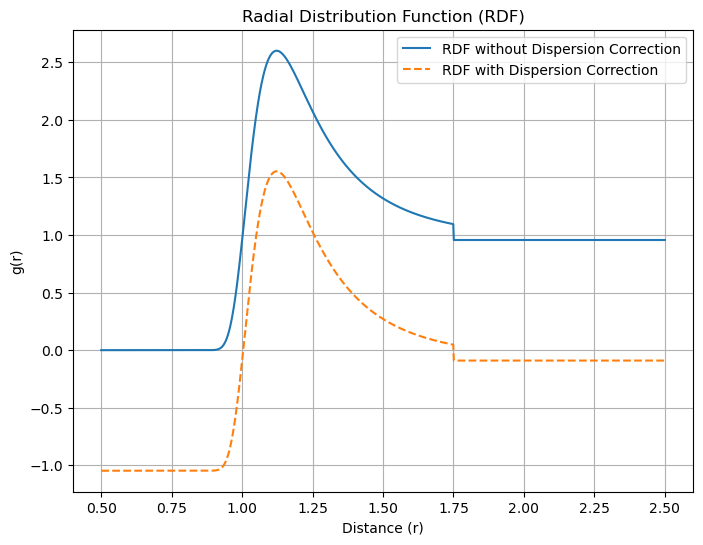

In [14]:

# Constants
sigma = 1.0
epsilon = 1.0
alpha = 0.5
lam = 0.5
rho = 1.0  # Density (number of particles per unit volume)
k_B = 1.0  # Boltzmann constant
T = 1.0    # Temperature
vdw_switch = 1.75
vdw = 2.0

# Function to compute RDF
def compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T):
    g_r = np.exp(-np.array([u_lj_sc_shift_fs(r_i, lam, sigma, epsilon, vdw_switch, vdw, alpha) for r_i in r_values]) / (k_B * T))
    g_r /= np.mean(g_r)  # Normalize RDF
    return g_r

# Distance range for RDF calculation
r_values = np.linspace(0.5, 2.5, 1000)
for lam in lambda_values:
    # Calculate RDF without dispersion correction
    g_r_no_corr = compute_rdf(r_values, lam, sigma, epsilon, vdw_switch, vdw, alpha, k_B, T)

    # Calculate RDF with dispersion correction
    disp_corr = -8 * np.pi * epsilon * (sigma**6) / (3 * vdw**3)
    g_r_with_corr = g_r_no_corr + lam * disp_corr

    # Plot RDFs
    plt.figure(figsize=(8, 6))
    plt.plot(r_values, g_r_no_corr, label='RDF without Dispersion Correction')
    plt.plot(r_values, g_r_with_corr, label='RDF with Dispersion Correction', linestyle='--')
    plt.xlabel('Distance (r)')
    plt.ylabel('g(r)')
    plt.title('Radial Distribution Function (RDF)')
    plt.legend()
    plt.grid(True)
    plt.show()

